In [1]:
%load_ext tensorboard

In [2]:
#pip install emot --upgrade

In [3]:
import numpy as np
import pandas as pd
import re
#import emot 
#from emot import EMOTICONS_EMO
import nltk
from nltk.stem.porter import PorterStemmer
import string
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import datetime, os

In [4]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/validation_data.csv')
target = pd.read_csv('dataset/comments_to_score.csv')
sample = pd.read_csv('dataset/sample_submission.csv')

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
train['y'] = train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1) > 0
train.drop(['toxic','severe_toxic','obscene','threat','insult','identity_hate'], inplace=True, axis=1)

In [7]:
train.head()

,id,comment_text,y
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False


In [8]:
train.y.unique()

array([False,  True])

<AxesSubplot:>

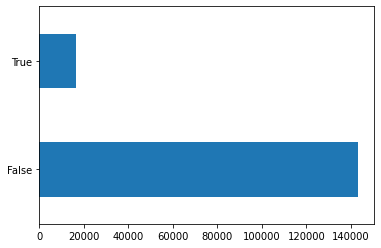

In [9]:
train.y.value_counts().plot(kind='barh')

In [10]:
count_of_toxic_comments =  train[train.y != 0].shape[0]
count_of_toxic_comments

16225

In [11]:
train_toxic = train[train.y != 0]
train_non_toxic = train[train.y == 0].sample(count_of_toxic_comments)

In [12]:
df = pd.concat([train_toxic, train_non_toxic])
df

,id,comment_text,y
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,True
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",True
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,True
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",True
...,...,...,...
50180,861f542e3a4bb53a,"""::You're right. I wish there was more of an ...",False
144161,08af65d6f113de00,I have added all the additional information fr...,False
128764,b0a46912dbde827c,"Woot: Go Terry, score some more goals buddy, y...",False
78347,d1a567c71345a4c5,kushwaha \nI respect your dalit activism. Howe...,False


<AxesSubplot:>

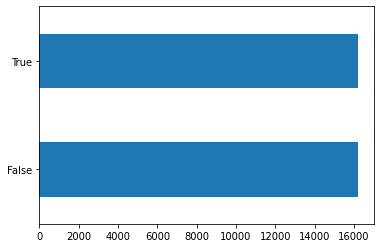

In [13]:
df.y.value_counts().plot(kind='barh')

In [14]:
# word_count
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['comment_text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
df.tail()

,id,comment_text,y,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
50180,861f542e3a4bb53a,"""::You're right. I wish there was more of an ...",False,69,54,38,4.434783,381,19
144161,08af65d6f113de00,I have added all the additional information fr...,False,35,26,15,4.200000,181,4
128764,b0a46912dbde827c,"Woot: Go Terry, score some more goals buddy, y...",False,22,22,7,4.545455,121,6
78347,d1a567c71345a4c5,kushwaha \nI respect your dalit activism. Howe...,False,51,47,23,4.862745,299,5
107510,3ec5181161541ce0,"""\nSorry to hear that you was blocked for the ...",False,18,17,9,4.055556,91,5


In [15]:
# #Spelling correction
# from spellchecker import SpellChecker

# spell = SpellChecker()
# def correct_spellings(text):
#     corrected_text = []
# #     misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)

# df["comment_text"]= df["comment_text"].apply(correct_spellings)

In [16]:
df.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
count,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000,32450.000000
mean,61.205362,41.807026,27.648197,5.034995,356.342866,15.438767
std,103.033547,49.857923,46.836112,15.123255,606.673513,62.885901
min,1.000000,1.000000,0.000000,1.000000,6.000000,0.000000
25%,14.000000,13.000000,6.000000,4.214286,77.000000,3.000000
50%,30.000000,26.000000,14.000000,4.608696,170.000000,7.000000
75%,65.000000,51.000000,31.000000,5.038370,373.000000,15.000000
max,1411.000000,816.000000,902.000000,1655.000000,5000.000000,4942.000000


In [17]:
# Remove stopwords & convert to lower case
#df['comment_text'] = df['comment_text'].apply(lambda text: remove_stopwords(text))
df['comment_text'] = df['comment_text'].apply(lambda x: ' '.join([w for w in str(x).lower().split() if w not in STOPWORDS]))

In [18]:
# Remove Punctuations
df["comment_text"] = df['comment_text'].str.replace('[^\w\s]','')

<ipython-input-18-188543086b1c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["comment_text"] = df['comment_text'].str.replace('[^\w\s]','')


In [19]:
# word_count
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['comment_text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
df.tail()

,id,comment_text,y,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
50180,861f542e3a4bb53a,youre right wish effort people include correct...,False,30,29,2,6.133333,214,0
144161,08af65d6f113de00,added additional information santa rosa beni p...,False,20,13,1,5.000000,119,0
128764,b0a46912dbde827c,woot go terry score goals buddy better way pla...,False,15,15,0,4.666667,84,0
78347,d1a567c71345a4c5,kushwaha respect dalit activism kushwaha neith...,False,28,26,1,6.214286,201,0
107510,3ec5181161541ce0,sorry hear blocked time guy v4711 victortalk,False,7,7,0,5.428571,46,0


In [20]:
#Removal of emojis

In [21]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

df["comment_text"]= df["comment_text"].apply(lambda string : remove_emoji(string))

In [22]:
# word_count
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['comment_text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
df.tail()

,id,comment_text,y,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
50180,861f542e3a4bb53a,youre right wish effort people include correct...,False,30,29,2,6.133333,214,0
144161,08af65d6f113de00,added additional information santa rosa beni p...,False,20,13,1,5.000000,119,0
128764,b0a46912dbde827c,woot go terry score goals buddy better way pla...,False,15,15,0,4.666667,84,0
78347,d1a567c71345a4c5,kushwaha respect dalit activism kushwaha neith...,False,28,26,1,6.214286,201,0
107510,3ec5181161541ce0,sorry hear blocked time guy v4711 victortalk,False,7,7,0,5.428571,46,0


In [23]:
#URL removal
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


df["comment_text"]= df["comment_text"].apply(lambda text : remove_urls(text))

In [24]:
# word_count
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['comment_text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
df.tail()

,id,comment_text,y,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
50180,861f542e3a4bb53a,youre right wish effort people include correct...,False,30,29,2,6.133333,214,0
144161,08af65d6f113de00,added additional information santa rosa beni p...,False,20,13,1,5.000000,119,0
128764,b0a46912dbde827c,woot go terry score goals buddy better way pla...,False,15,15,0,4.666667,84,0
78347,d1a567c71345a4c5,kushwaha respect dalit activism kushwaha neith...,False,28,26,1,6.214286,201,0
107510,3ec5181161541ce0,sorry hear blocked time guy v4711 victortalk,False,7,7,0,5.428571,46,0


In [25]:
#Stemming

In [26]:
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df["comment_text"] = df["comment_text"].apply(lambda text: stem_words(text))

In [27]:
# word_count
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['comment_text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
df.tail()

,id,comment_text,y,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
50180,861f542e3a4bb53a,your right wish effort peopl includ correct in...,False,30,28,3,5.366667,190,0
144161,08af65d6f113de00,ad addit inform santa rosa beni page santa ros...,False,20,13,1,4.300000,105,0
128764,b0a46912dbde827c,woot go terri score goal buddi better way play...,False,15,15,0,4.266667,78,0
78347,d1a567c71345a4c5,kushwaha respect dalit activ kushwaha neither ...,False,28,25,1,5.500000,181,0
107510,3ec5181161541ce0,sorri hear block time guy v4711 victortalk,False,7,7,0,5.142857,42,0


In [28]:
X = df.drop(['y'], axis=1)
y = df['y']

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [30]:
X_train.head()

,id,comment_text,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
76690,cd64e48fc4b0d0bf,quot you dumb bastard realli understand anyth,7,7,1,5.571429,45,0
88218,ebf77e3298407a4d,persib persib again pleas leav true fuck you m...,25,19,2,5.400000,159,0
118013,766997bfc92e84cc,hate you hate you,4,2,2,3.500000,17,0
67770,b554c337ff97e3da,time wait wikia support repli pleas unblock me...,40,25,3,4.650000,225,0
71352,bf01285eec9b3811,loser loserthat atheisty total lostno guidanc ...,27,27,1,5.814815,183,0


In [31]:
X_train = X_train.comment_text.values
X_test = X_test.comment_text.values

In [32]:
y_train.head()

76690      True
88218      True
118013     True
67770     False
71352      True
Name: y, dtype: bool

In [33]:
OOV_TOKEN = '<OOV>'
VOCAB_SIZE = 10000
MAX_LEN = 120
EMBEDDING_DIM = 100

In [34]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE,oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

In [35]:
len(tokenizer.word_index)

52350

In [36]:
unique_token_count = len(tokenizer.word_counts) + 2

In [37]:
train_seq = tokenizer.texts_to_sequences(X_train)

In [38]:
test_seq = tokenizer.texts_to_sequences(X_test)

In [39]:
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_seq, maxlen=MAX_LEN, dtype='int32', padding='post',
    truncating='post')

In [40]:
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=MAX_LEN, dtype='int32', padding='post',truncating='post')

In [41]:
test_padded.shape

(8113, 120)

In [42]:
n_features = X.shape[1]

In [43]:
n_features 

8

In [44]:
#Training

In [45]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(0.001)

In [48]:
def create_mlp_model():
    '''return tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(unique_token_count, 16),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu', kernel_initializer = 'he_normal', input_shape = (n_features,)),
    tf.keras.layers.Dense(10, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(1)
    ])'''
    return tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(unique_token_count, 16),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation = 'relu', kernel_initializer = 'he_normal', input_shape = (n_features,)),
    tf.keras.layers.Dense(5, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(5, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(5, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(1),
    ])

In [49]:
def train_model():

  model = create_mlp_model()
  model.compile(loss='mean_squared_error',optimizer=optimizer,
                metrics=['accuracy'])
  log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  model.fit(train_padded,y = y_train,validation_data=(test_padded, y_test), epochs=100, batch_size=128, verbose = 2, shuffle=True, validation_split=0.2,callbacks=[tensorboard_callback])
  return model

model = train_model()

Epoch 1/100
153/153 - 5s - loss: 0.1516 - accuracy: 0.7936 - val_loss: 0.1055 - val_accuracy: 0.8694
Epoch 2/100
153/153 - 2s - loss: 0.0671 - accuracy: 0.9194 - val_loss: 0.0923 - val_accuracy: 0.8753
Epoch 3/100
153/153 - 2s - loss: 0.0378 - accuracy: 0.9565 - val_loss: 0.0961 - val_accuracy: 0.8720
Epoch 4/100
153/153 - 2s - loss: 0.0239 - accuracy: 0.9731 - val_loss: 0.0992 - val_accuracy: 0.8745
Epoch 5/100
153/153 - 2s - loss: 0.0170 - accuracy: 0.9813 - val_loss: 0.1036 - val_accuracy: 0.8704
Epoch 6/100
153/153 - 2s - loss: 0.0131 - accuracy: 0.9862 - val_loss: 0.1063 - val_accuracy: 0.8722
Epoch 7/100
153/153 - 2s - loss: 0.0108 - accuracy: 0.9886 - val_loss: 0.1067 - val_accuracy: 0.8728
Epoch 8/100
153/153 - 2s - loss: 0.0092 - accuracy: 0.9907 - val_loss: 0.1109 - val_accuracy: 0.8718
Epoch 9/100
153/153 - 2s - loss: 0.0079 - accuracy: 0.9921 - val_loss: 0.1136 - val_accuracy: 0.8710
Epoch 10/100
153/153 - 2s - loss: 0.0072 - accuracy: 0.9926 - val_loss: 0.1094 - val_accura

Epoch 82/100
153/153 - 2s - loss: 0.0015 - accuracy: 0.9985 - val_loss: 0.1283 - val_accuracy: 0.8603
Epoch 83/100
153/153 - 2s - loss: 0.0017 - accuracy: 0.9983 - val_loss: 0.1253 - val_accuracy: 0.8648
Epoch 84/100
153/153 - 2s - loss: 0.0019 - accuracy: 0.9981 - val_loss: 0.1294 - val_accuracy: 0.8556
Epoch 85/100
153/153 - 2s - loss: 0.0022 - accuracy: 0.9975 - val_loss: 0.1281 - val_accuracy: 0.8611
Epoch 86/100
153/153 - 2s - loss: 0.0021 - accuracy: 0.9977 - val_loss: 0.1270 - val_accuracy: 0.8632
Epoch 87/100
153/153 - 2s - loss: 0.0016 - accuracy: 0.9985 - val_loss: 0.1277 - val_accuracy: 0.8620
Epoch 88/100
153/153 - 2s - loss: 0.0017 - accuracy: 0.9984 - val_loss: 0.1289 - val_accuracy: 0.8603
Epoch 89/100
153/153 - 2s - loss: 0.0016 - accuracy: 0.9984 - val_loss: 0.1307 - val_accuracy: 0.8603
Epoch 90/100
153/153 - 2s - loss: 0.0015 - accuracy: 0.9985 - val_loss: 0.1304 - val_accuracy: 0.8609
Epoch 91/100
153/153 - 2s - loss: 0.0015 - accuracy: 0.9985 - val_loss: 0.1295 - v

In [50]:
%tensorboard --logdir logs/fit --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 2136), started 4:51:10 ago. (Use '!kill 2136' to kill it.)

In [ ]:
target.head()

In [ ]:
df_target = target

In [ ]:
df_target['text'] = df_target['text'].apply(lambda text: stem_words(text))

In [ ]:
# Remove stopwords & convert to lower case
df_target['text'] = df_target['text'].apply(lambda x: ' '.join([w for w in str(x).lower().split() if w not in STOPWORDS]))

In [ ]:
# Remove Punctuations
df_target["text"] = df_target['text'].str.replace('[^\w\s]','')

In [ ]:
df_target["text"] = df_target['text'].apply(remove_emoji)

In [ ]:
df_target["text"] = df_target['text'].apply(remove_urls)

In [ ]:
target_seq = tokenizer.texts_to_sequences(df_target.text.values)
target_padded = pad_sequences(
    target_seq, maxlen=MAX_LEN, dtype='int32', padding='post',
    truncating='post'
)

In [ ]:
result = model.predict(target_padded)

In [ ]:
target['score'] = result

In [ ]:
from scipy.stats import rankdata

In [ ]:
target['score']= rankdata( target['score'], method='ordinal') 

In [ ]:
target[['comment_id','score']].to_csv('submission.csv', index=False)